### BAGIAN 0: Pendahuluan & Pemuatan Aset Proyek🏆
Bagian awal ini berfungsi sebagai fondasi untuk analisis dan evaluasi kinerja model. Tahap ini krusial untuk memastikan semua sumber daya yang diperlukan siap sebelum melakukan penilaian komparatif. Prosesnya meliputi pemuatan seluruh library penting yang dibutuhkan untuk analisis dan visualisasi. Selanjutnya, dataset uji yang telah dipersiapkan dari dua skenario eksperimen—yaitu dengan dan tanpa reduksi dimensi PCA (Principal Component Analysis)—akan dimuat. Terakhir, semua model prediktif (.pkl) yang telah dioptimasi dari berbagai algoritma akan diimpor, siap untuk dievaluasi secara sistematis dalam upaya mengidentifikasi solusi terbaik.

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import joblib

# Membuat direktori output jika belum ada
os.makedirs('hasil_gambar/confusion_matrix', exist_ok=True)
os.makedirs('hasil_model', exist_ok=True)

### BAGIAN 1: PEMBERSIHAN DATA 🚀
Bagian ini menguraikan tahapan krusial dalam pra-pemrosesan data. Proses diawali dengan akuisisi dan penggabungan data mentah dari berbagai file sumber menjadi satu dataset komprehensif. Selanjutnya, dilakukan inspeksi awal untuk memahami struktur data dan mengidentifikasi keberadaan nilai-nilai yang hilang (missing values). Sesuai dengan metodologi yang telah ditetapkan, langkah pembersihan data melibatkan penghapusan baris yang memiliki nilai tidak lengkap (incomplete rows) untuk memastikan kualitas dan kelengkapan data sebelum pemodelan.

In [2]:
#--- [SETUP AWAL] Definisikan nama kolom sesuai dokumentasi dataset ---
column_names = [
    'age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 
    'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal', 'num'
]

#--- [PENGUMPULAN DATA] Fungsi untuk memuat data dari satu file ---
def load_data(file_path):
    """Memuat file CSV, mendefinisikan nama kolom, dan mengonversi '?' menjadi NaN."""
    try:
        return pd.read_csv(file_path, header=None, names=column_names, na_values='?')
    except FileNotFoundError:
        print(f"⚠️ File {file_path} tidak ditemukan. Melewati...")
        return None

# --- [PENGGABUNGAN DATA] Muat dan gabungkan semua dataset ---
# Pastikan path ini sesuai dengan struktur direktori Anda
data_path = 'data/heart+disease/' 
df_cleveland = load_data(os.path.join(data_path, 'processed.cleveland.data'))
df_hungarian = load_data(os.path.join(data_path, 'processed.hungarian.data'))
df_switzerland = load_data(os.path.join(data_path, 'processed.switzerland.data'))
df_va = load_data(os.path.join(data_path, 'processed.va.data'))

# Gabungkan semua DataFrame yang berhasil dimuat
list_of_dfs = [df for df in [df_cleveland, df_hungarian, df_switzerland, df_va] if df is not None]
if not list_of_dfs:
    raise ValueError("Tidak ada dataset yang berhasil dimuat. Periksa kembali path folder data Anda.")
    
df_full = pd.concat(list_of_dfs, ignore_index=True)

print(f"✅ Total data mentah yang berhasil digabungkan: {df_full.shape[0]} baris dan {df_full.shape[1]} kolom.")
print("\n--- Analisis Data Mentah (Sebelum Cleaning) ---")

print("\nJumlah Missing Values di Setiap Kolom:")
print(df_full.isnull().sum())

#--- [PEMBERSIHAN DATA DENGAN STRATEGI DROPNA] ---
print("\n--- Memulai Proses Pembersihan Data (Metode: Dropna) ---")

# Sesuai laporan, kita pakai metode drop untuk menangani missing value
df_cleaned_dropna = df_full.dropna().copy()
print(f"Jumlah baris setelah menghapus missing values: {df_cleaned_dropna.shape[0]}")

if df_cleaned_dropna.isnull().sum().sum() == 0:
    print("✅ Konfirmasi: Tidak ada lagi missing values dalam data.")

# --- BARIS BARU: Tampilkan hasil setelah cleaning ---
print("\nLima baris pertama data setelah dibersihkan (df_cleaned_dropna):")
print(df_cleaned_dropna.head())
# --- AKHIR BARIS BARU ---

# Ekspor data yang sudah bersih dan siap untuk pemodelan
output_filename_clean = 'data/dataset_prediksi_jantung_clean_dropna.csv'
df_cleaned_dropna.to_csv(output_filename_clean, index=False)
print(f"\n✅ Data bersih (dropna) telah diekspor ke '{output_filename_clean}'.")

✅ Total data mentah yang berhasil digabungkan: 920 baris dan 14 kolom.

--- Analisis Data Mentah (Sebelum Cleaning) ---

Jumlah Missing Values di Setiap Kolom:
age           0
sex           0
cp            0
trestbps     59
chol         30
fbs          90
restecg       2
thalach      55
exang        55
oldpeak      62
slope       309
ca          611
thal        486
num           0
dtype: int64

--- Memulai Proses Pembersihan Data (Metode: Dropna) ---
Jumlah baris setelah menghapus missing values: 299
✅ Konfirmasi: Tidak ada lagi missing values dalam data.

Lima baris pertama data setelah dibersihkan (df_cleaned_dropna):
    age  sex   cp  trestbps   chol  fbs  restecg  thalach  exang  oldpeak  \
0  63.0  1.0  1.0     145.0  233.0  1.0      2.0    150.0    0.0      2.3   
1  67.0  1.0  4.0     160.0  286.0  0.0      2.0    108.0    1.0      1.5   
2  67.0  1.0  4.0     120.0  229.0  0.0      2.0    129.0    1.0      2.6   
3  37.0  1.0  3.0     130.0  250.0  0.0      0.0    187.0    0.0

### BAGIAN 2: PERSIAPAN DATA UNTUK PEMODELAN 📂
Tahap ini berfokus pada persiapan dataset yang telah bersih untuk proses pemodelan. Langkah-langkahnya meliputi pemuatan data, transformasi variabel target menjadi format biner, pemisahan antara fitur (X) dan target (y), serta pembagian dataset menjadi data latih (75%) dan data uji (25%). Penggunaan parameter stratify memastikan proporsi kelas target tetap seimbang di kedua set data, yang esensial untuk validasi model yang robust.

In [3]:
#--- [PERSIAPAN DATA UNTUK MODELING] ---
# Muat data bersih yang akan digunakan untuk eksperimen ini
try:
    df = pd.read_csv('data/dataset_prediksi_jantung_clean_dropna.csv')
    print(f"✅ Data bersih (dropna) berhasil dimuat untuk pemodelan. Shape: {df.shape}")
except FileNotFoundError:
    raise FileNotFoundError("File 'data/dataset_prediksi_jantung_clean_dropna.csv' tidak ditemukan. Jalankan Bagian 1 terlebih dahulu.")

# Transformasi variabel target 'num' menjadi biner (0: Tidak Sakit, 1: Sakit)
df['target'] = (df['num'] > 0).astype(int)

# Definisikan fitur (X) dan target (y)
X = df.drop(['num', 'target'], axis=1)
y = df['target']

# Bagi data menjadi data latih (75%) dan data uji (25%)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)
print(f"Data telah dibagi menjadi: {len(X_train)} data latih dan {len(X_test)} data uji.")

✅ Data bersih (dropna) berhasil dimuat untuk pemodelan. Shape: (299, 14)
Data telah dibagi menjadi: 224 data latih dan 75 data uji.


### BAGIAN 3: PELATIHAN MODEL & OPTIMASI HYPERPARAMETER ⚙️
Bagian ini telah direstrukturisasi untuk menjalankan dua eksperimen secara paralel: satu menggunakan set fitur lengkap (Non-PCA) dan satu lagi menggunakan fitur yang telah direduksi dimensinya dengan Principal Component Analysis (PCA). Setiap skenario akan melalui proses GridSearchCV untuk menemukan hyperparameter optimal, dan model terbaik dari setiap algoritma akan disimpan secara terpisah, ditandai dengan nama skenarionya untuk memudahkan identifikasi pada tahap evaluasi.

In [4]:
#--- [SETUP SKENARIO & MODEL] ---
preprocessor = StandardScaler()

# Definisikan pipeline untuk setiap skenario
pipelines = {
    'Non-PCA': Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', None) # Placeholder untuk classifier
    ]),
    'PCA': Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('pca', PCA(n_components=8, random_state=42)), # Menggunakan 8 komponen utama
        ('classifier', None) # Placeholder untuk classifier
    ])
}

models = {
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'Random Forest': RandomForestClassifier(random_state=42),
    'XGBoost': XGBClassifier(random_state=42, eval_metric='logloss'),
    'SVC': SVC(random_state=42, probability=True)
}

# Definisikan hyperparameter grid (tetap sama, pipeline akan menanganinya)
param_grids = {
    'Logistic Regression': {
        'classifier__C': [0.1, 1, 10, 100],
        'classifier__solver': ['liblinear', 'lbfgs']
    },
    'Random Forest': {
        'classifier__n_estimators': [100, 200, 300],
        'classifier__max_depth': [5, 8, 10, None],
        'classifier__min_samples_split': [2, 5]
    },
    'XGBoost': {
        'classifier__learning_rate': [0.01, 0.1, 0.2],
        'classifier__n_estimators': [100, 200],
        'classifier__max_depth': [3, 5, 7]
    },
    'SVC': {
        'classifier__C': [0.1, 1, 10],
        'classifier__kernel': ['rbf', 'linear'],
        'classifier__gamma': ['scale', 'auto']
    }
}

#--- [TRAINING & TUNING LOOP UNTUK SETIAP SKENARIO] ---
trained_models_all_scenarios = {}

for scenario_name, pipeline_template in pipelines.items():
    print(f"\n{'='*25} MEMULAI SKENARIO: {scenario_name} {'='*25}")
    trained_models_scenario = {}
    
    for model_name, model_instance in models.items():
        print(f"\n--- ⚙️  Training Model: {model_name} ({scenario_name}) ---")

        # Set classifier pada pipeline
        pipeline = pipeline_template
        pipeline.set_params(classifier=model_instance)

        grid_search = GridSearchCV(
            pipeline, 
            param_grids[model_name], 
            cv=5, 
            scoring='accuracy', 
            n_jobs=-1
        )
        
        grid_search.fit(X_train, y_train)
        
        print(f"🔥 Best Parameters: {grid_search.best_params_}")
        print(f"🎯 Best Cross-Validation Accuracy: {grid_search.best_score_:.4f}")
        
        best_estimator = grid_search.best_estimator_
        trained_models_scenario[model_name] = best_estimator
        
        # Simpan model dengan nama yang menyertakan skenario
        output_path = f'hasil_model/{scenario_name}_{model_name.replace(" ", "_")}_model.pkl'
        joblib.dump(best_estimator, output_path)
        print(f"✅ Model telah disimpan di: {output_path}")

    trained_models_all_scenarios[scenario_name] = trained_models_scenario


========================= MEMULAI SKENARIO: Non-PCA =========================

--- ⚙️  Training Model: Logistic Regression (Non-PCA) ---
🔥 Best Parameters: {'classifier__C': 0.1, 'classifier__solver': 'liblinear'}
🎯 Best Cross-Validation Accuracy: 0.8218
✅ Model telah disimpan di: hasil_model/Non-PCA_Logistic_Regression_model.pkl

--- ⚙️  Training Model: Random Forest (Non-PCA) ---
🔥 Best Parameters: {'classifier__max_depth': 5, 'classifier__min_samples_split': 5, 'classifier__n_estimators': 100}
🎯 Best Cross-Validation Accuracy: 0.8349
✅ Model telah disimpan di: hasil_model/Non-PCA_Random_Forest_model.pkl

--- ⚙️  Training Model: XGBoost (Non-PCA) ---
🔥 Best Parameters: {'classifier__learning_rate': 0.2, 'classifier__max_depth': 7, 'classifier__n_estimators': 100}
🎯 Best Cross-Validation Accuracy: 0.8262
✅ Model telah disimpan di: hasil_model/Non-PCA_XGBoost_model.pkl

--- ⚙️  Training Model: SVC (Non-PCA) ---
🔥 Best Parameters: {'classifier__C': 0.1, 'classifier__gamma': 'scale', 'c

### BAGIAN 4: EVALUASI MODEL & ANALISIS HASIL 📊
Pada tahap akhir ini, semua model dari setiap skenario (Non-PCA dan PCA) dievaluasi kinerjanya menggunakan data uji. Untuk setiap model, metrik evaluasi yang komprehensif (Akurasi, Presisi, Recall, F1-Score, ROC-AUC) dihitung. Confusion Matrix divisualisasikan dengan format detail, lalu diekspor sebagai file gambar. Puncaknya, sebuah grafik perbandingan akhir yang merangkum semua metrik kinerja dibuat untuk setiap skenario, memungkinkan analisis komparatif yang mendalam untuk menentukan pendekatan dan model yang paling unggul.


========================= EVALUASI AKHIR SKENARIO: Non-PCA =========================

--- 📊 Evaluasi Model: Logistic Regression (Non-PCA) ---
Classification Report (pada Data Uji - Non-PCA):
                 precision    recall  f1-score   support

Tidak Sakit (0)       0.83      0.88      0.85        40
      Sakit (1)       0.85      0.80      0.82        35

       accuracy                           0.84        75
      macro avg       0.84      0.84      0.84        75
   weighted avg       0.84      0.84      0.84        75

✅ Confusion Matrix disimpan ke: hasil_gambar/confusion_matrix/CM_Non-PCA_Logistic_Regression.png


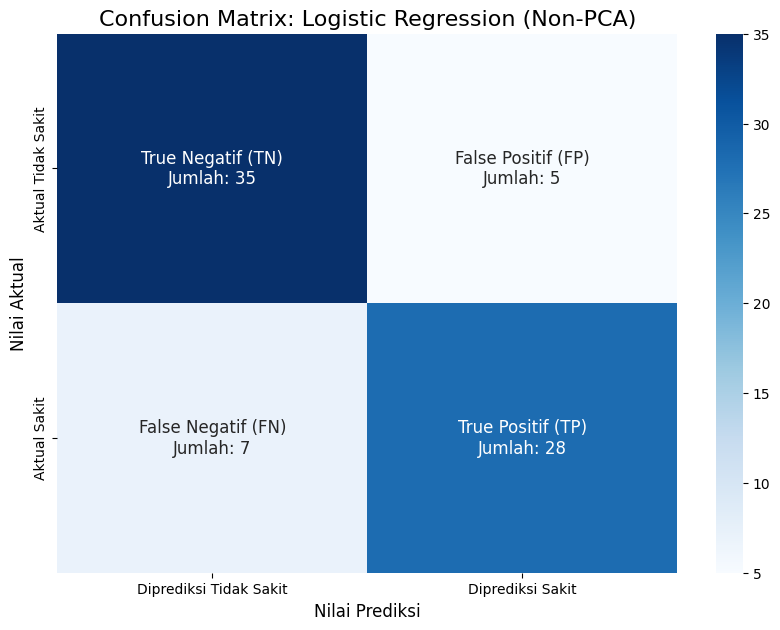


--- 📊 Evaluasi Model: Random Forest (Non-PCA) ---
Classification Report (pada Data Uji - Non-PCA):
                 precision    recall  f1-score   support

Tidak Sakit (0)       0.77      0.93      0.84        40
      Sakit (1)       0.89      0.69      0.77        35

       accuracy                           0.81        75
      macro avg       0.83      0.81      0.81        75
   weighted avg       0.83      0.81      0.81        75

✅ Confusion Matrix disimpan ke: hasil_gambar/confusion_matrix/CM_Non-PCA_Random_Forest.png


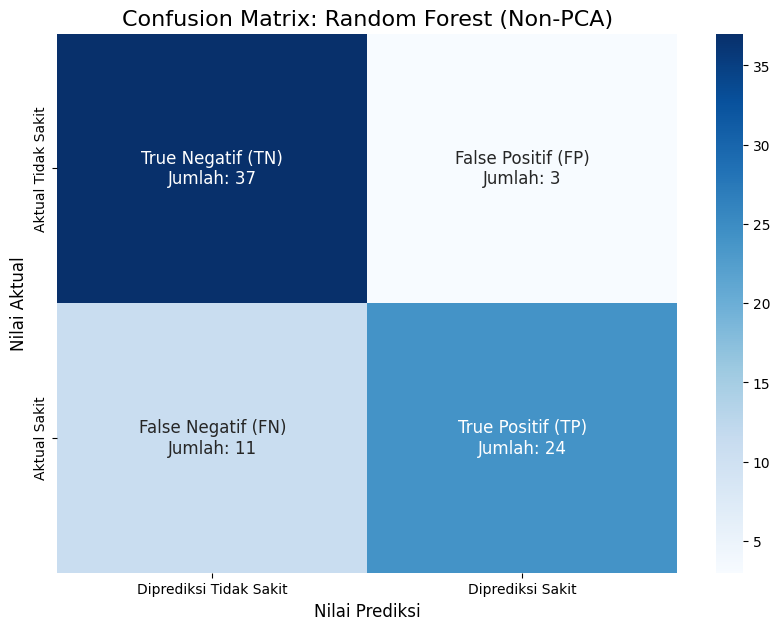


--- 📊 Evaluasi Model: XGBoost (Non-PCA) ---
Classification Report (pada Data Uji - Non-PCA):
                 precision    recall  f1-score   support

Tidak Sakit (0)       0.74      0.88      0.80        40
      Sakit (1)       0.82      0.66      0.73        35

       accuracy                           0.77        75
      macro avg       0.78      0.77      0.77        75
   weighted avg       0.78      0.77      0.77        75

✅ Confusion Matrix disimpan ke: hasil_gambar/confusion_matrix/CM_Non-PCA_XGBoost.png


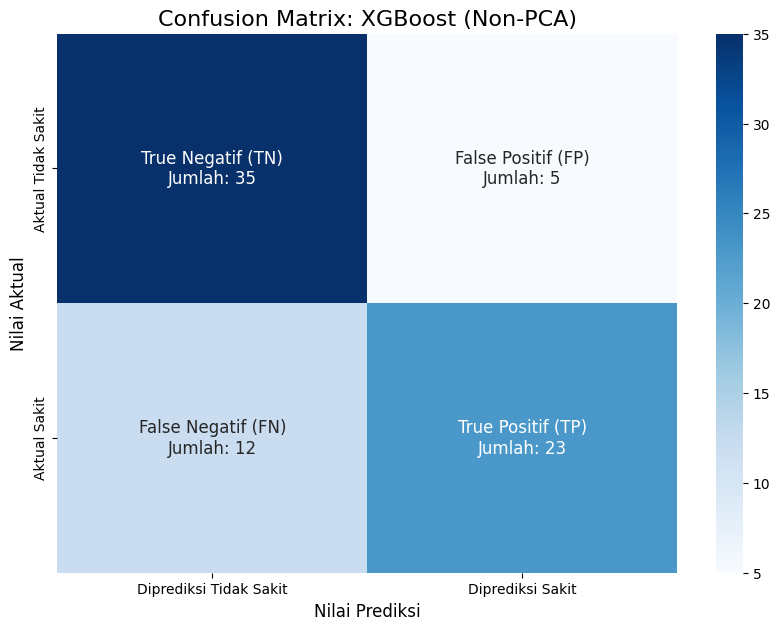


--- 📊 Evaluasi Model: SVC (Non-PCA) ---
Classification Report (pada Data Uji - Non-PCA):
                 precision    recall  f1-score   support

Tidak Sakit (0)       0.84      0.90      0.87        40
      Sakit (1)       0.88      0.80      0.84        35

       accuracy                           0.85        75
      macro avg       0.86      0.85      0.85        75
   weighted avg       0.85      0.85      0.85        75

✅ Confusion Matrix disimpan ke: hasil_gambar/confusion_matrix/CM_Non-PCA_SVC.png


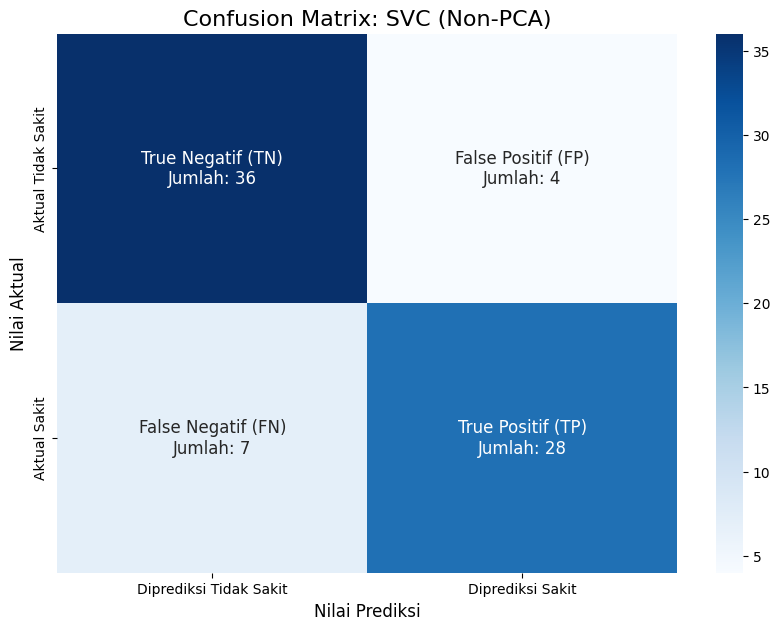


--- Ringkasan Hasil Performa Model (Non-PCA) ---
                 Model  Accuracy  Precision    Recall  F1-Score   ROC-AUC
0  Logistic Regression  0.840000   0.848485  0.800000  0.823529  0.930714
1        Random Forest  0.813333   0.888889  0.685714  0.774194  0.923571
2              XGBoost  0.773333   0.821429  0.657143  0.730159  0.870714
3                  SVC  0.853333   0.875000  0.800000  0.835821  0.941429
✅ Grafik perbandingan kinerja disimpan ke: hasil_gambar/Perbandingan_Kinerja_Akhir_Non-PCA.png


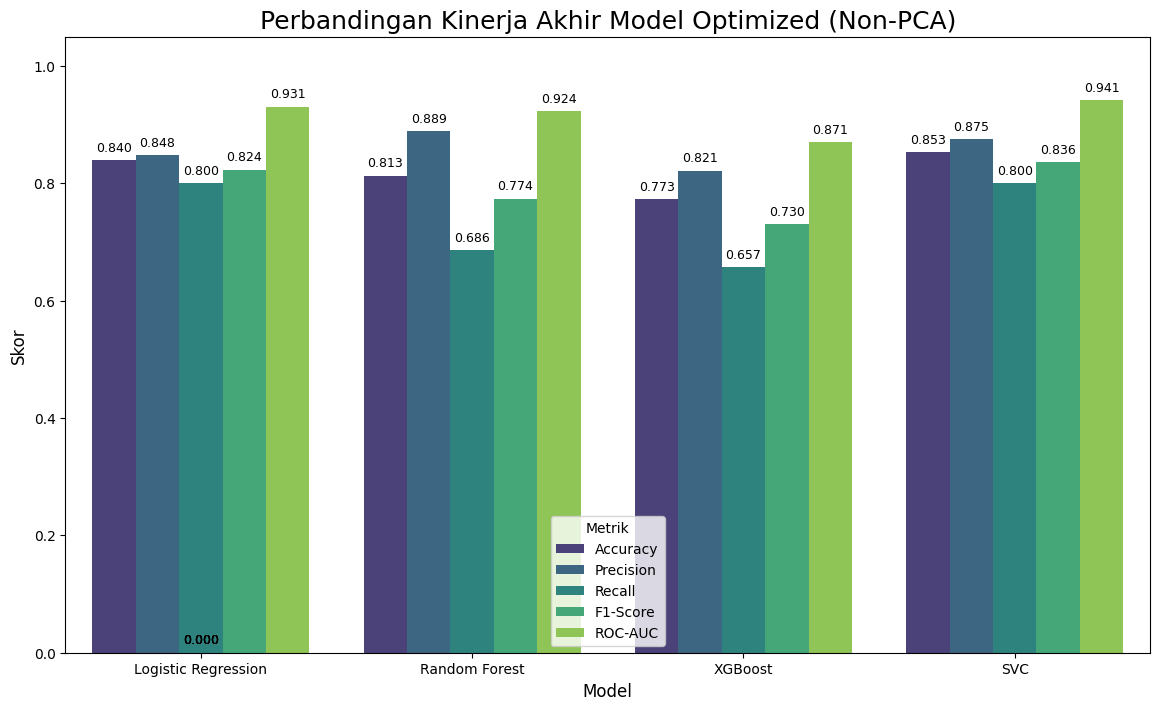


========================= EVALUASI AKHIR SKENARIO: PCA =========================

--- 📊 Evaluasi Model: Logistic Regression (PCA) ---
Classification Report (pada Data Uji - PCA):
                 precision    recall  f1-score   support

Tidak Sakit (0)       0.85      0.85      0.85        40
      Sakit (1)       0.83      0.83      0.83        35

       accuracy                           0.84        75
      macro avg       0.84      0.84      0.84        75
   weighted avg       0.84      0.84      0.84        75

✅ Confusion Matrix disimpan ke: hasil_gambar/confusion_matrix/CM_PCA_Logistic_Regression.png


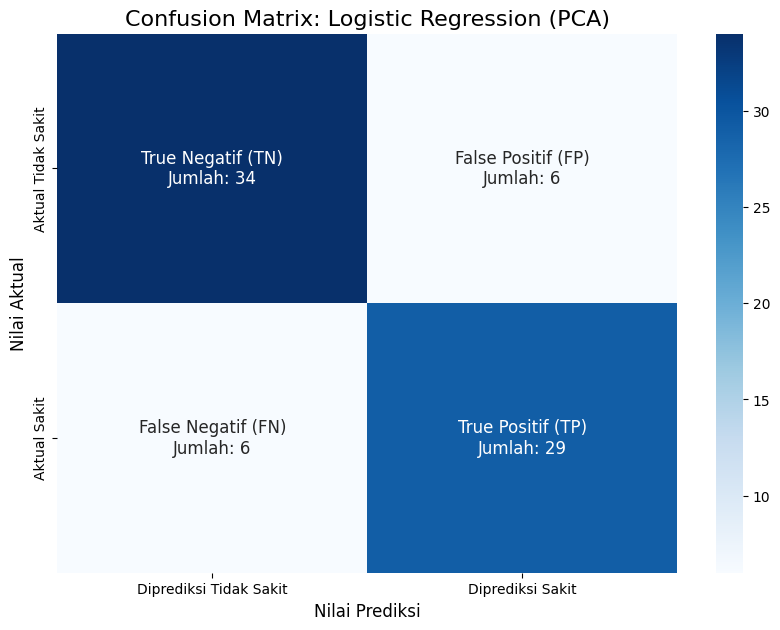


--- 📊 Evaluasi Model: Random Forest (PCA) ---
Classification Report (pada Data Uji - PCA):
                 precision    recall  f1-score   support

Tidak Sakit (0)       0.79      0.93      0.85        40
      Sakit (1)       0.89      0.71      0.79        35

       accuracy                           0.83        75
      macro avg       0.84      0.82      0.82        75
   weighted avg       0.84      0.83      0.82        75

✅ Confusion Matrix disimpan ke: hasil_gambar/confusion_matrix/CM_PCA_Random_Forest.png


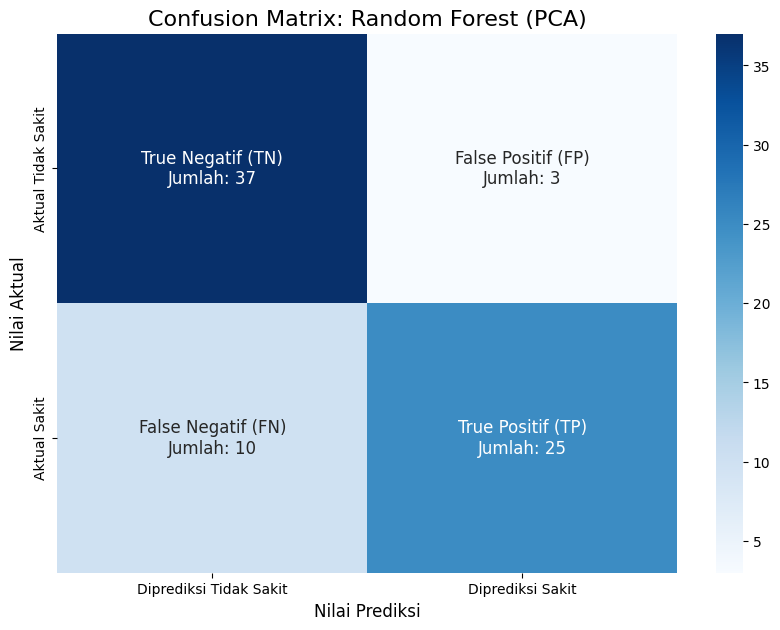


--- 📊 Evaluasi Model: XGBoost (PCA) ---
Classification Report (pada Data Uji - PCA):
                 precision    recall  f1-score   support

Tidak Sakit (0)       0.76      0.93      0.83        40
      Sakit (1)       0.88      0.66      0.75        35

       accuracy                           0.80        75
      macro avg       0.82      0.79      0.79        75
   weighted avg       0.82      0.80      0.80        75

✅ Confusion Matrix disimpan ke: hasil_gambar/confusion_matrix/CM_PCA_XGBoost.png


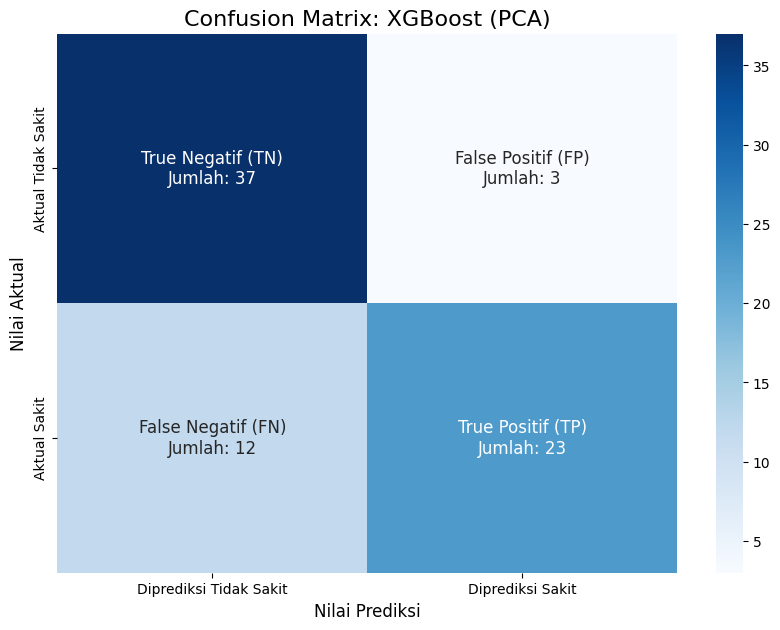


--- 📊 Evaluasi Model: SVC (PCA) ---
Classification Report (pada Data Uji - PCA):
                 precision    recall  f1-score   support

Tidak Sakit (0)       0.79      0.95      0.86        40
      Sakit (1)       0.93      0.71      0.81        35

       accuracy                           0.84        75
      macro avg       0.86      0.83      0.84        75
   weighted avg       0.85      0.84      0.84        75

✅ Confusion Matrix disimpan ke: hasil_gambar/confusion_matrix/CM_PCA_SVC.png


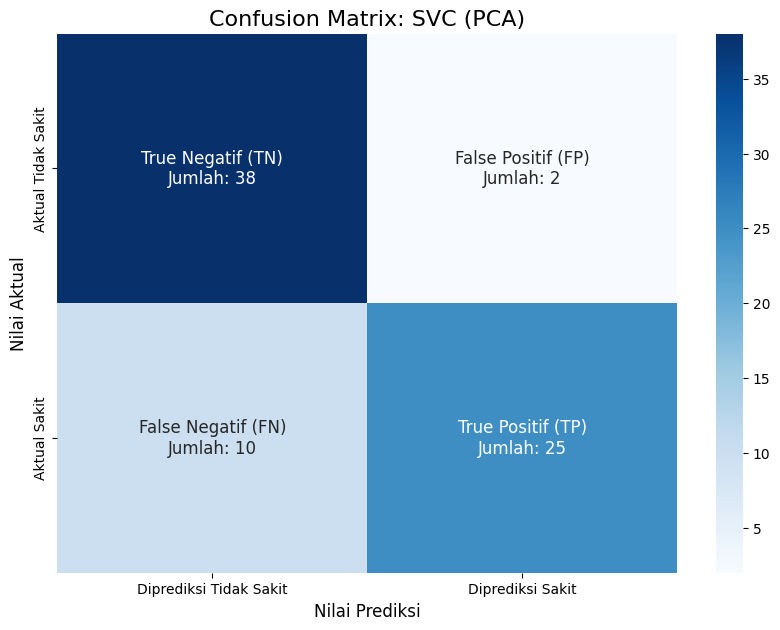


--- Ringkasan Hasil Performa Model (PCA) ---
                 Model  Accuracy  Precision    Recall  F1-Score   ROC-AUC
0  Logistic Regression  0.840000   0.828571  0.828571  0.828571  0.920714
1        Random Forest  0.826667   0.892857  0.714286  0.793651  0.918571
2              XGBoost  0.800000   0.884615  0.657143  0.754098  0.907857
3                  SVC  0.840000   0.925926  0.714286  0.806452  0.921786
✅ Grafik perbandingan kinerja disimpan ke: hasil_gambar/Perbandingan_Kinerja_Akhir_PCA.png


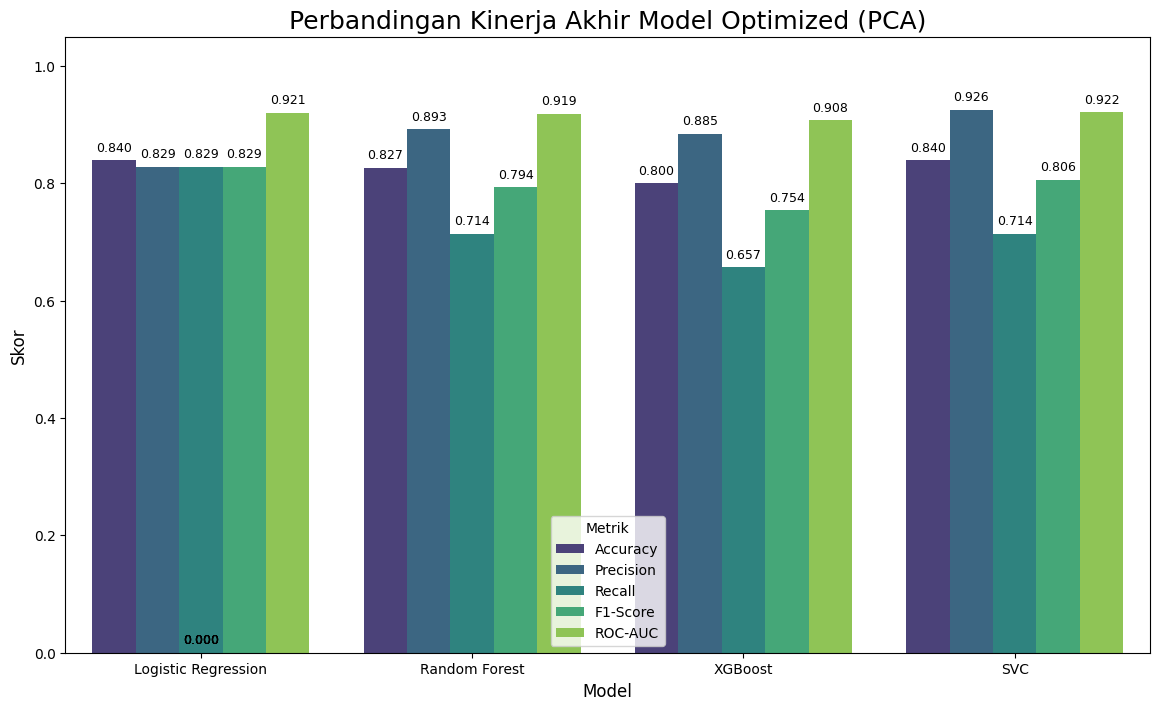

In [5]:
def plot_detailed_confusion_matrix(cm, model_name, scenario_name):
    """Fungsi untuk membuat plot confusion matrix dengan format detail."""
    
    # Ekstrak nilai TN, FP, FN, TP
    tn, fp, fn, tp = cm.ravel()
    
    # Buat label untuk setiap sel
    labels = np.array([
        [f'True Negatif (TN)\nJumlah: {tn}', f'False Positif (FP)\nJumlah: {fp}'],
        [f'False Negatif (FN)\nJumlah: {fn}', f'True Positif (TP)\nJumlah: {tp}']
    ])
    
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=labels, fmt='', cmap='Blues',
                xticklabels=['Diprediksi Tidak Sakit', 'Diprediksi Sakit'],
                yticklabels=['Aktual Tidak Sakit', 'Aktual Sakit'],
                annot_kws={"size": 12}) # Mengatur ukuran font anotasi
    plt.title(f'Confusion Matrix: {model_name} ({scenario_name})', fontsize=16)
    plt.ylabel('Nilai Aktual', fontsize=12)
    plt.xlabel('Nilai Prediksi', fontsize=12)
    
    output_path = f'hasil_gambar/confusion_matrix/CM_{scenario_name}_{model_name.replace(" ", "_")}.png'
    plt.savefig(output_path, bbox_inches='tight')
    print(f"✅ Confusion Matrix disimpan ke: {output_path}")
    plt.show()


def plot_comparison_chart(df_results, scenario_name):
    """Fungsi untuk membuat grafik perbandingan akhir untuk semua metrik."""
    
    # 'Melt' dataframe agar sesuai untuk barplot seaborn
    df_melted = df_results.melt(id_vars='Model', var_name='Metrik', value_name='Skor')
    
    plt.figure(figsize=(14, 8))
    ax = sns.barplot(x='Model', y='Skor', hue='Metrik', data=df_melted, palette='viridis')
    plt.title(f'Perbandingan Kinerja Akhir Model Optimized ({scenario_name})', fontsize=18)
    plt.xlabel('Model', fontsize=12)
    plt.ylabel('Skor', fontsize=12)
    plt.ylim(0, 1.05)
    plt.legend(title='Metrik')
    
    # Tambahkan label angka di atas setiap bar
    for p in ax.patches:
        ax.annotate(f'{p.get_height():.3f}', 
                    (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha='center', va='center', 
                    xytext=(0, 9), 
                    textcoords='offset points',
                    fontsize=9)
                    
    output_path = f'hasil_gambar/Perbandingan_Kinerja_Akhir_{scenario_name}.png'
    plt.savefig(output_path, bbox_inches='tight')
    print(f"✅ Grafik perbandingan kinerja disimpan ke: {output_path}")
    plt.show()

#--- [LOOP EVALUASI UNTUK SETIAP SKENARIO] ---
for scenario_name, trained_models in trained_models_all_scenarios.items():
    print(f"\n{'='*25} EVALUASI AKHIR SKENARIO: {scenario_name} {'='*25}")
    evaluation_results = []

    for model_name, model in trained_models.items():
        print(f"\n--- 📊 Evaluasi Model: {model_name} ({scenario_name}) ---")
        
        y_pred = model.predict(X_test)
        y_pred_proba = model.predict_proba(X_test)[:, 1] # Probabilitas untuk kelas positif (1)
        
        # Hitung semua metrik
        metrics = {
            'Model': model_name,
            'Accuracy': accuracy_score(y_test, y_pred),
            'Precision': precision_score(y_test, y_pred),
            'Recall': recall_score(y_test, y_pred),
            'F1-Score': f1_score(y_test, y_pred),
            'ROC-AUC': roc_auc_score(y_test, y_pred_proba)
        }
        evaluation_results.append(metrics)
        
        print(f"Classification Report (pada Data Uji - {scenario_name}):")
        print(classification_report(y_test, y_pred, target_names=['Tidak Sakit (0)', 'Sakit (1)']))
        
        # Plot confusion matrix detail
        cm = confusion_matrix(y_test, y_pred)
        plot_detailed_confusion_matrix(cm, model_name, scenario_name)

    # Buat dan tampilkan tabel ringkasan
    results_df = pd.DataFrame(evaluation_results)
    print(f"\n--- Ringkasan Hasil Performa Model ({scenario_name}) ---")
    print(results_df.to_string())
    
    # Buat dan tampilkan grafik perbandingan akhir
    plot_comparison_chart(results_df, scenario_name)

### BAGIAN 5: ANALISIS KOMPARATIF & PEMILIHAN MODEL FINAL 🏆
Setelah semua model dari kedua skenario (Non-PCA dan PCA) dievaluasi, tahap ini berfokus pada analisis komparatif untuk secara objektif menentukan satu model dengan kinerja terbaik secara keseluruhan. Proses ini dilakukan dengan mengkonsolidasikan semua hasil evaluasi, mengidentifikasi model juara berdasarkan metrik kunci, dan memuat model tersebut untuk penggunaan lebih lanjut.

In [6]:
# List untuk menampung dataframe hasil dari setiap skenario
all_results_dfs = []

# Loop melalui hasil dari Bagian 4 dan tambahkan kolom 'Scenario'
for scenario_name, trained_models in trained_models_all_scenarios.items():
    evaluation_results = []
    for model_name, model in trained_models.items():
        y_pred = model.predict(X_test)
        y_pred_proba = model.predict_proba(X_test)[:, 1]
        
        metrics = {
            'Scenario': scenario_name, # Tambahkan nama skenario
            'Model': model_name,
            'Accuracy': accuracy_score(y_test, y_pred),
            'Precision': precision_score(y_test, y_pred),
            'Recall': recall_score(y_test, y_pred),
            'F1-Score': f1_score(y_test, y_pred),
            'ROC-AUC': roc_auc_score(y_test, y_pred_proba)
        }
        evaluation_results.append(metrics)
    
    all_results_dfs.append(pd.DataFrame(evaluation_results))

# Gabungkan semua hasil menjadi satu DataFrame
all_results_df = pd.concat(all_results_dfs, ignore_index=True)

# Urutkan berdasarkan Akurasi dan ROC-AUC untuk menemukan yang terbaik
ranked_results = all_results_df.sort_values(by=['Accuracy', 'ROC-AUC'], ascending=[False, False]).reset_index(drop=True)

print("--- Tabel Peringkat Komprehensif (Semua Skenario) ---")
print(ranked_results.to_string())

--- Tabel Peringkat Komprehensif (Semua Skenario) ---
  Scenario                Model  Accuracy  Precision    Recall  F1-Score   ROC-AUC
0  Non-PCA                  SVC  0.853333   0.875000  0.800000  0.835821  0.941429
1  Non-PCA  Logistic Regression  0.840000   0.848485  0.800000  0.823529  0.930714
2      PCA                  SVC  0.840000   0.925926  0.714286  0.806452  0.921786
3      PCA  Logistic Regression  0.840000   0.828571  0.828571  0.828571  0.920714
4      PCA        Random Forest  0.826667   0.892857  0.714286  0.793651  0.918571
5  Non-PCA        Random Forest  0.813333   0.888889  0.685714  0.774194  0.923571
6      PCA              XGBoost  0.800000   0.884615  0.657143  0.754098  0.907857
7  Non-PCA              XGBoost  0.773333   0.821429  0.657143  0.730159  0.870714
